# Optimization Homework 3
Here are just some simple codes for the homework.
I follow [Numerical Recipes in C](https://www.cec.uchile.cl/cinetica/pcordero/MC_libros/NumericalRecipesinC.pdf)
for the overall algorithm.

For the first part of the problem we find the linear approximation of this set of points.

In [272]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import line_search
from sklearn.linear_model import LinearRegression # For comparision

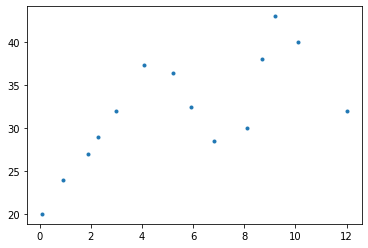

In [273]:
X = np.array([0.1, 0.9, 1.9, 2.3, 3, 4.1, 5.2, 5.9, 6.8, 8.1,
    8.7, 9.2, 10.1, 12])
Y = np.array([20, 24, 27, 29, 32, 37.3, 36.4, 32.4, 28.5,
             30, 38, 43, 40, 32])
plt.plot(X, Y, '.')

# Variance
In the book they assume that each point has its own variance $\sigma_i$, but here we just use the same $\sigma$ for all the points.

The terms of the formula are:
$$ S = \sum_{i=1}^{N}\frac{1}{\sigma^2_i}\quad S_x=\sum_{i=1}^{N}\frac{x_i}{\sigma^2_i} \quad S_y = \sum_{i=1}^{N}\frac{y_i}{\sigma_i^2}$$
$$S_{xx} = \sum_{i=1}^{N}\frac{x_i^2}{\sigma_i^2}\quad S_{xy}=\sum_{i=1}^{N}\frac{x_i y_i}{\sigma_i^2}$$

In [274]:
def optimize(X, Y):
    m, b = 0, 0
    npoints = X.shape[0]
    iterations = 100
    lr = 0.001
    i = 0
    while i < 1000:
        preds = X * m + b
        dm =(-2/npoints)* np.sum(X * (Y - preds))
        db = (-2/npoints)*(np.sum(Y - preds))
        m -= (dm * lr)
        b -= (db * lr)
        
        i += 1
    return m, b

## Plot the Estimate Line
Initial estimate given arbitrary variance.

[[4.42186916]]


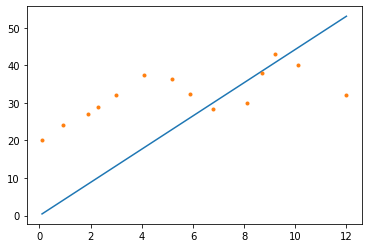

In [275]:
'''
i = 0
while i < 1:
    a, b = optimize(X, Y)
    print(a,b)
    preds = X * a + b
    #var = np.sum(np.power(Y - preds, 2) / (N - M)) 
    #print(var)
    plt.plot(X, Y, 'b.')
    plt.plot(X, preds, 'r')
    i += 1
'''
x = X.reshape(len(X), 1)
y = Y.reshape(len(Y), 1)
m = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))
print(m)
plt.plot(x, x.dot(m))
plt.plot(x, y, '.')
plt.savefig('./report/img/p1Linear.png')
plt.show()

## `sklearn`'s Linear Regression for comparison

[1.16758943]


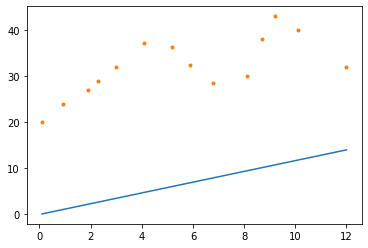

In [276]:
model  = LinearRegression().fit(X.reshape(-1, 1), Y)
print(model.coef_)
plt.plot(X, X * model.coef_ )
plt.plot(X, Y, '.')
plt.show()


##  Find best quadratic coefficients
Calculate it by the formulas:
$$\bar{x} = \frac{1}{n}=\sum_{i=1}^{N} x_i\quad \bar{x}^2 = \sum_{i=1}^{n}x_i^2\quad\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$$
$$S_{xx} = \sum_{i=1}^{n}(x_i - \bar{x})^2$$
$$S_{xy} = \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})$$
$$S_{xx^2} = \sum_{i=1}^{n}(x_i - \bar{x})(x_i^2 - \bar{x}^2)$$
$$S_{x^2x^2} = \sum_{i=1}^{n}(x_i^2 - \bar{x}^2)^2$$
$$S{x^2y} = \sum_{i=1}^{n}(x_i^2-\bar{x}^2)(y_i-\bar{y})$$

[-0.2068715   3.56671917 21.26212718]


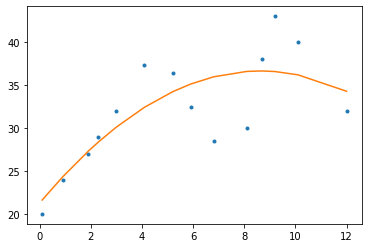

In [277]:
def fit_quadratic(x, y):
    x2 = np.power(x, 2)
    xbar = np.mean(x)
    xbar2 = np.mean(x*x)
    ybar = np.mean(y)

    Sxx = np.sum(np.power(x -xbar, 2))
    Sxy = np.dot((x-xbar), (y-ybar))
    Sxx2 = np.sum((x-xbar)*(np.power(x, 2) - xbar2))
    Sx2x2 = np.sum(np.power(x2 - xbar2, 2))
    Sx2y = np.dot((x2 - xbar2),(y - ybar))
    #print(Sxx,Sxy,  Sxx2, Sx2x2, Sx2y)
    
    den = Sxx*Sx2x2 - (Sxx2 ** 2) + .01
    c = (Sx2y * Sxx - Sxy * Sxx2) / den 
    b = (Sxy*Sx2x2 - Sx2y*Sxx2) / den
    a = ybar - b*xbar - c*xbar2
    
    #print(f'C: {c}, b: {b}, a: {a}')
    return np.array([c, b, a])
guess = fit_quadratic(X, Y)
print(guess)
preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
plt.plot(X, Y, '.')
plt.plot(X, preds)
plt.savefig('./report/img/p1Quad.png')
plt.show()

## Quadratic Regression
The quadratic function is 
$$f(x) = ax^2 + bx + c$$

To find the optimal $(a, b, c)$, we can solve the system of equations
$$ a\sum x_i^4 + b\sum x_i^3 + c\sum x_i^2 = \sum x_i^2 y$$
$$ a\sum x_i^3 + b\sum x_i^2 + c\sum x_i = \sum x_i y$$
$$ a\sum x_i^2 + b\sum x_i + cn_i = \sum y_i$$

We use an online solver to arrive at the optimal values of $a, b, c$.

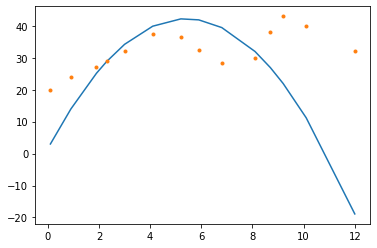

In [278]:
a = -1.4
b = 15.1
c = 1.51
preds = a * np.power(X, 2) + b * X + c

plt.plot(X, preds)
plt.plot(X,Y, '.')
plt.show()

## Armijo's Line Search
For a given point $x$, calculate $f(\lambda)$ and compare it to $f(x) + \lambda\epsilon f'(x)$ to determine if we should reduce $\lambda$ or
increase it.

In [365]:
# Return best alpha along given search direction p
def armijo(x, y, preds, guess, linear):
    tol = 1e-2
    f = objective(x, y, preds, guess)
    alpha = .00001
    #print(linear)
    m = np.dot(gradient(x, y, preds, guess, linear).T, guess)
    c, tau = 0.5, 0.5
    t = -c*m
    while f - objective(X , Y, preds,  guess + alpha*guess, linear) >= alpha * t:
        alpha = tau * alpha
        if alpha < tol:
            break
    return alpha
    
    #print(flamb, forig, grad)
    

# 2
Using Fletcher-Reeves, and either Newton or Quasi-Newton method, find the best fit linear and quadratic lines numerically.
For the quadratic gradient, we should instead try to use :
$$\bar{x} = \frac{1}{n}=\sum_{i=1}^{N} x_i\quad \bar{x}^2 = \sum_{i=1}^{n}x_i^2\quad\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$$
$$S_{xx} = \sum_{i=1}^{n}(x_i - \bar{x})^2$$
$$S_{xy} = \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})$$
$$S_{xx^2} = \sum_{i=1}^{n}(x_i - \bar{x})(x_i^2 - \bar{x}^2)$$
$$S_{x^2x^2} = \sum_{i=1}^{n}(x_i^2 - \bar{x}^2)^2$$
$$S{x^2y} = \sum_{i=1}^{n}(x_i^2-\bar{x}^2)(y_i-\bar{y})$$

## Fletcher Reeves


[1.98426822 0.32775971]


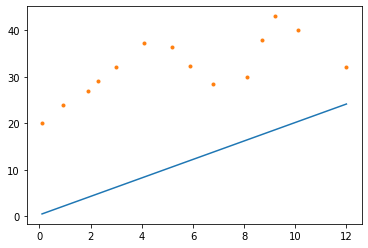

In [385]:
# Quadratic regression error gradient
def error(Y, preds):
    return np.sum(np.power(Y-preds, 2)) / (Y.shape[0])

def objective(x, y, preds, p, linear=True):
    N = x.shape[0]
    # Not sure if we should calculate preds here or individually in methods?
    
    if linear:
        tmp = p[0] * x + p[1]
    else:
        tmp = p[0] * np.power(x, 2) + p[1] * x  + p[2]
        
    ret =  (1/N) * np.sum(np.power((y - tmp), 2))
    return ret

def gradient(X, Y, preds, guess, linear=True):
    if linear:
        return linear_gradient(X, Y, preds, guess)
    return quad_gradient(X, Y, preds, guess)
def quad_gradient(x, y, preds, guess):

    size = preds.shape[0]
    den = -2 / size
    tmp = guess[0] * np.power(x, 2) + guess[1] * x + guess[2]
    dyda = np.sum((y - tmp)*(x*x)) * den 

    dydb = np.sum((y - tmp)*x) * den 
    dydc = np.sum((y-tmp)) * den 
    return np.array([dyda, dydb, dydc]) 
    
def linear_gradient( x, y, preds, guess):
    size = x.shape[0]
    den = -2/size
    preds = guess[0] * X + guess[1]
    dydw = np.sum((y - preds)*x) *den
    dyda = np.sum((y - preds)) * den
    ret = np.array([dydw, dyda])
    return ret / (size * size)

def get_lambda(guess, S):
    denom = S / np.linalg.norm(S, ord=2)
    a = -guess[0]  * denom
    b = -guess[1] * denom
    c = -guess[2] * denom
    ret =  np.array([np.linalg.norm(a),
                     np.linalg.norm(b),
                     np.linalg.norm(c)]) 
    return ret

tol = 0.5
#Basically get the first iteration
guess = np.array([0, 0])
preds = X * guess[0] + guess[1]

grad = linear_gradient(X, Y, preds, guess)
S = -grad

#print(error(Y, preds))
guess = guess + (S)
i = 0
#lamb = .002
# TODO: Still need to find lambda better
while i < 10:
    prev_grad = grad
    grad = linear_gradient(X, Y, preds, guess)
    S = -grad + ((np.power(np.linalg.norm(grad),2))/(np.power(np.linalg.norm(prev_grad),2)))*S
    #lamb *= -1
    lamb = armijo(X, Y, preds, guess, True)

    guess = guess + (lamb * S)
    preds = guess[0] * X + guess[1]
    #print(guess, grad)
    i += 1
print(guess)
plt.plot(X, preds)
plt.plot(X, Y, '.')
plt.savefig('./report/img/FRLinear.png')

### Fletcher-Reeves on Quadratic Function
The procedure is the same, except we add the quadratic term in our loss function, and our gradient.

[0.35901062 0.57237185 0.23638057]


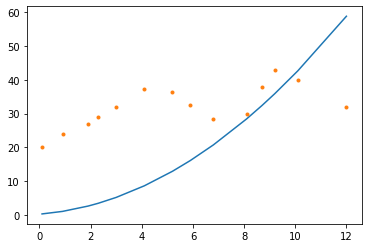

In [384]:
guess = np.array([0, 0, 0]) # Initial point
preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
grad = gradient(X, Y, preds, guess, linear=False)
S = -grad
#lamb = armijo(X, Y, preds, S, linear=False)
guess = guess +(lamb * S)
i = 0
while i < 50:
    prev_grad = grad
    grad = gradient(X, Y, X, guess, False)
    #print(error(Y, preds))
    S = -grad + (np.power(np.linalg.norm(grad),2) / np.power(np.linalg.norm(prev_grad), 2))*S
    lamb = armijo(X, Y, preds, S, False)
    guess = guess + (lamb * S)
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
    if np.linalg.norm(grad) < 1:
        break
    #print(grad, guess)
    #print('\n')
    i += 1
print(guess)
plt.plot(X, preds)
plt.plot(X, Y, '.')
plt.savefig('./report/img/FRQuad.png')

### Quasi-Newton's Method
With quasi-Newton methods, we try to approximate the original Hessian matrix $H$ of second order partial derivatives with another matrix $B$.

Here we try the BFGS method.


[0 0] [-0.19839431 -0.03276968]
2.010824608306412


[-0.19839431 -0.03276968] [-0.27453802  0.06463387]
2.1023948971384123


[-0.27453802  0.06463387] [-0.04571636  0.46952806]
2.131165492453578


[-0.04571636  0.46952806] [-1.56342387 -0.88296506]
2.0042687701336805


[-1.56342387 -0.88296506] [2.42700744 3.33845207]
2.7687471508579793


[2.42700744 3.33845207] [-0.51211899  0.45426363]
0.7213773549915331
Tolerance reached


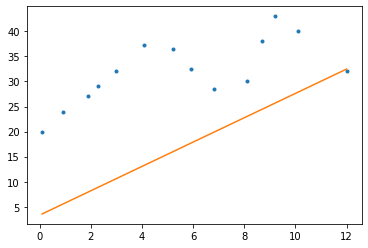

In [386]:
tol = 0.001
guess = np.array(([0, 0]))
B = np.eye(guess.shape[0]) # nxn Identity matrix
next_guess = guess
i = 0

while i < 100:
    preds = guess[0] * X + guess[1] 
    grad = linear_gradient(X, Y, preds, guess)



    S = -np.dot(B, grad) # Initial Search Direction
    lamb = -.1 # Initial step along line
    next_guess = guess + (lamb * S)
    g = linear_gradient(X, Y, preds, next_guess) - grad
    d = next_guess - guess
    M = 1 + np.matmul(np.matmul(g.T, B), g) / (np.dot(d.T, g))

    N = -(np.matmul(d, np.matmul(g.T, B))) / (np.dot(d.T, g))

    Q = -(np.matmul(np.matmul(B, g), d.T)) / (np.dot(d.T, g))
    B = B + M + N + Q
    print(guess, next_guess)
    #print(objective(X, Y, preds, guess))
    print(np.linalg.norm(grad))
    guess = next_guess
    if np.linalg.norm(grad) < 1:
        print('Tolerance reached')
        break
    print('\n')
    i += 1
plt.plot(X, Y, '.')
plt.plot(X, preds, '-')
plt.savefig('./report/img/BFGSLinear.png')
plt.show()

## Quadratic BFGS
Run the same algorithm with a quadratic approximation

Best guess: [-0.2212904   3.54665385 21.15616002]
Error: 15.813535281200027


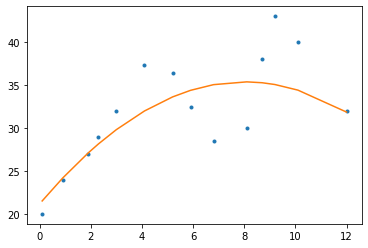

In [388]:
tol = 3
guess = np.array(([0.0, 0.0,0.0 ]))
B = np.eye(guess.shape[0]) # nxn Identity matrix
next_guess = guess
i = 0
while i < 1000:
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]

    grad = gradient(X, Y, preds, guess, False)
    if np.linalg.norm(grad) < tol:
        print('tolerance reached')
        break
    S = -np.dot(B, grad)
    lamb = armijo(X,Y, preds, guess, linear=False)
    next_guess = guess + (lamb * S)
    next_grad = gradient(X, Y, preds, next_guess, False)
    if np.linalg.norm(S) < tol:
        print('tolerance also reached')
        break
    #print(np.linalg.norm(next_grad))
    g = (next_grad - grad).reshape((3,1))
    d = (next_guess - guess).reshape((3,1))
    M = (1 + (np.dot(g.T,np.dot(B, g)) / (np.dot(d.T, g))))
    M = M[0,0] * (np.dot(d, d.T)/np.dot(d.T, g))

    N = -(np.matmul(np.matmul(d,g.T), B)) / (np.dot(d.T, g))
    Q = -(np.matmul(np.matmul(B, g), d.T)) / (np.dot(d.T, g))
    B = B + M + N + Q
    #print(B, M , N, Q)
    #print(guess, next_guess, np.linalg.norm(grad), np.linalg.norm(next_grad))

    guess = next_guess
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
    i += 1
    
print(f'Best guess: {S}')
preds = S[0] * np.power(X, 2) + S[1] * X + S[2]

print(f'Error: {error(Y, preds)}')
plt.plot(X, Y, '.')
plt.plot(X, preds )
plt.savefig('./report/img/BFGSQuad.png')
plt.show()


# 3. Polynomial Regression
Decide the order of the polynomial that best fits the data points. We use numpy to find the regression order that minimizes the least squares error.

67.35301175472974
56.63825505154167
19.55482941470184
55.248985865663236
58.840331003472514
13.86305116090655


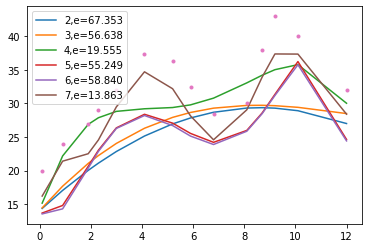

In [265]:
def get_preds(X, Y, cos):
    exp = cos.shape[0] - 1
    preds = np.array((X.shape))
    for i, exp in enumerate(range(exp, 0, -1)):
        preds = preds +(cos[i] * np.power(X, exp))
    return preds
        
        
max_deg = 8
for deg in range(2, max_deg):
    coeff = np.polyfit(X, Y, deg)
    preds = get_preds(X, Y, coeff)
    plt.plot(X, preds, '-', label=f'{deg},e={error(Y, preds):.3f}')
    print(error(Y, preds))
plt.plot(X, Y, '.')
plt.legend()
plt.savefig('./report/img/p3.png')
plt.show()

## 4. Create our own model
Use your creativity to construct the regression model (i.e. combining polynomial, sin, cos, exponential, and/or log functions) which best fits the data. For example, you may assume that $y = c_1\sin(x) + c_2e^x$ , where $c_1$ and $c_2$ are the coefficients to be determined. Also, describe your reasons for choosing certain functions in your model.

Tentative function: $$f(x) = c_1x\log(x + c_2\sin(x))$$
Reasoning: The data points "curve" a little inward, similar to the $\log$ function, and the points appear like a wave, similar to a polynomial or $\sin$. The parameters $c_1, c_2$ roughly control the angle at which the function increases and the amplitude, respectively.

To optimize our model, we just perform gradient descent for a number of iterations.quad_Bursar’s

317.8986337097916


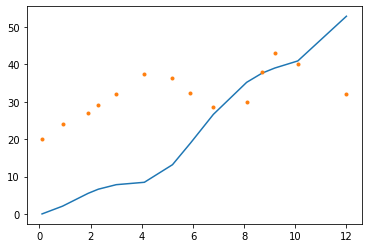

In [271]:
def func(x, p):
    return  p[0] * x * np.log(1 + x + p[1]*np.sin(x))

def our_gradient(x, p):
    a = x * np.log(x + p[1] * np.sin(x)) # dfda is just the objective without a
    b = (a * x * np.sin(x))/ (p[1] * np.sin(x) + x)
    return np.array([a, b])
    
iterations = 20000
i = 0
p = np.array([0.0, 0.0])
lr = .001
size = X.shape[0]

while i < iterations:
    preds = func(X, p)
    grad = our_gradient(X, p)
    
    dc1 = (-2/size) * (np.sum((Y - preds) * grad[0]))
    dc2 = (-2/size) * (np.sum((Y - preds) * grad[1]))
    #print(p, error(Y, preds))
    p[0] -=  (dc1 * lr)
    p[1] -= (dc2 * lr)
    i += 1
print(error(Y, func(X, p)))
    
plt.plot(X, func(X, p))
plt.plot(X, Y, '.')
plt.savefig('./report/img/p4OwnModel.png')
plt.show()